Import the libraries

In [1]:
import os

import tensorflow as tf

import numpy as np
import pandas as pd
import random
import sklearn.preprocessing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

!pip install seasonal

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rc('font', size=16)
figsize=(12,9)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# set the random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load and inspect the original dataset

In [3]:
#read the dataset from csv file using pandas dataframe
#dataset = pd.read_csv("Training.csv")
dataset = pd.read_csv("/kaggle/input/training/Training.csv")
print(dataset.shape)
dataset.head()  #show first rows of the dataframe

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
#print some statistical values about the data
dataset.describe()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000
mean,6.094102,4.695539,13.337485,2.448660,2.407010,23.237929,8.231283
std,1.941639,3.374224,11.703203,3.001798,0.994063,14.298260,11.285101
min,-0.972080,-8.450380,-37.581721,-9.028060,-1.275860,-6.006860,-42.769221
25%,4.791440,2.223420,10.672820,0.468800,2.112200,12.560240,6.604160
50%,5.702780,4.668600,15.676059,2.533840,2.618500,20.151420,10.968300
75%,7.067300,7.115440,20.568080,4.656980,3.021880,31.245199,15.334100
max,15.106680,18.122899,41.138801,14.035980,6.056360,77.371620,31.024420


In [5]:
#print some other information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


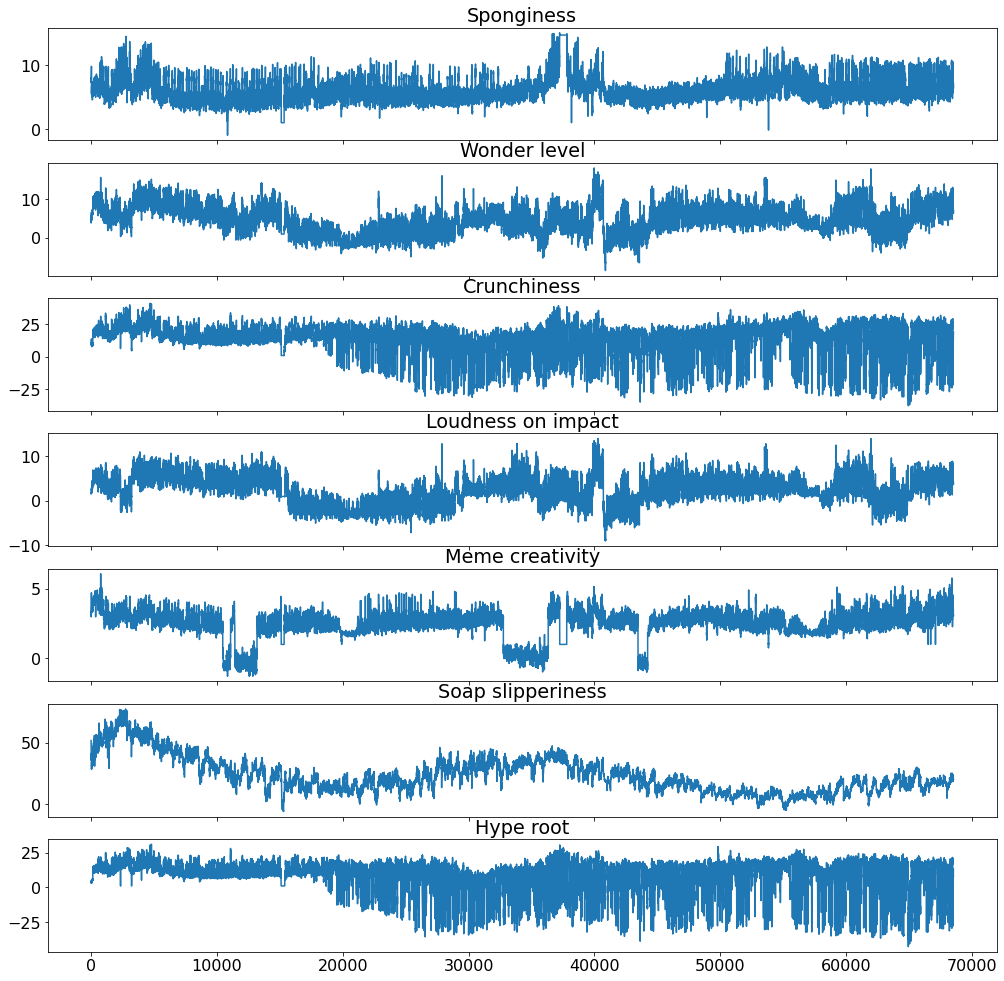

In [6]:
#function to plot the dataset, dividing it in subplots, one for each feature
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

inspect_dataframe(dataset, dataset.columns)

# CORRELATION

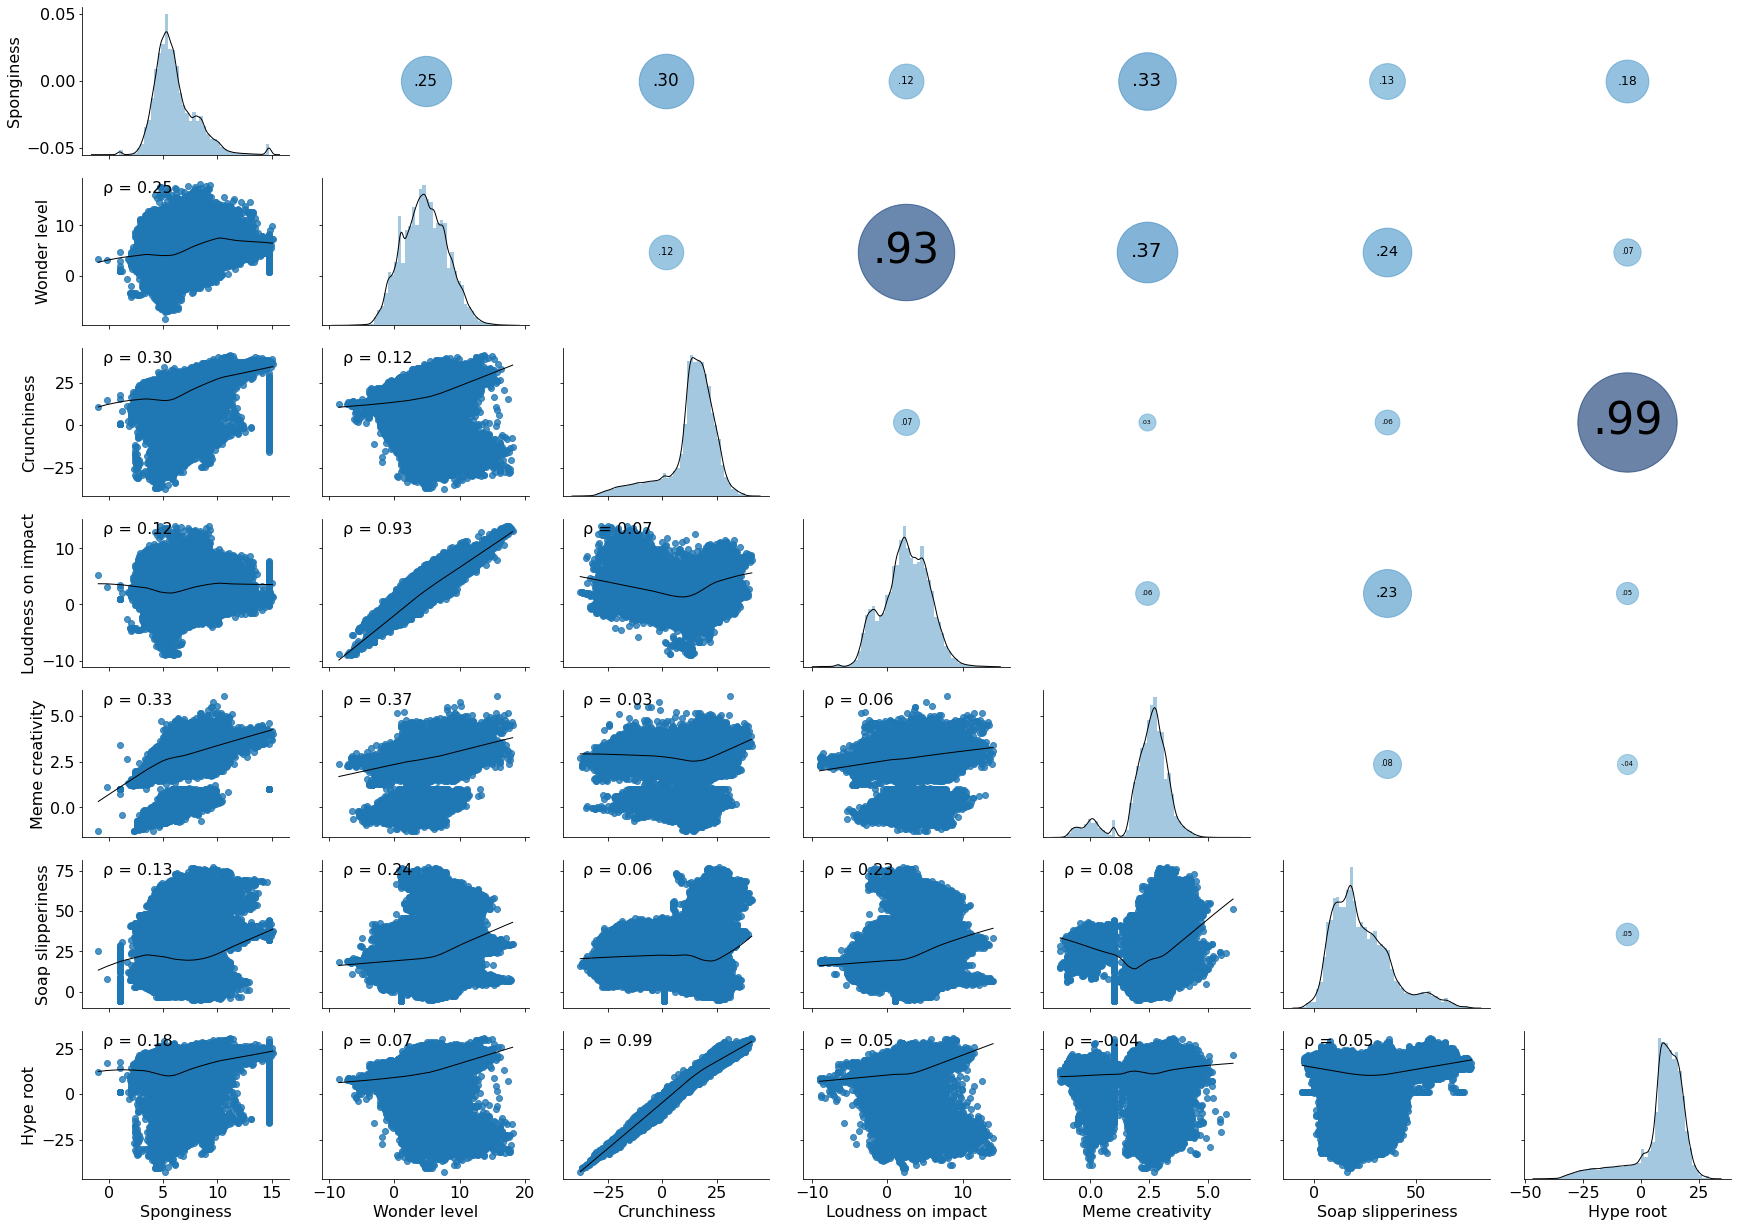

In [7]:
#function to compute the Pearson's correlation coeffients between the data series

from scipy.stats import pearsonr

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="Blues",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    
    
# g = sns.pairplot(stocks,palette=["Blues_d"])
g = sns.PairGrid(dataset, aspect=1.4, diag_sharey=False)
g.map_lower(corrfunc)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'Black','linewidth':1})
g.map_diag(sns.distplot, kde_kws={'color': 'Black','linewidth':1})
g.map_upper(corrdot)
plt.show()

# AUTOCORRELATION

In [8]:
from statsmodels.tsa.stattools import adfuller

#autocorrelation
for i in range(7):
    print(dataset[str(dataset.columns[i])].autocorr())
    adf = adfuller(dataset[str(dataset.columns[i])])
    print("p-value of "+str(dataset.columns[i])+": %.4f"%adf[1])
    
#Any substantial non-zero autocorrelations implies that the series can be forecast from the past.

#"In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample."

#Pt−Pt−1=μ+ϵt 
#A random walk with drift is also called unit root. if a time series has a unit root, it shows a systematic pattern that is unpredictable.
#To check whether a series is stationary, we can apply the Augmented Dickey fuller test.
#has p-value 0.0000 which is less than than 0.05, null hypothesis that the series is random walk it is rejected

0.9701337114852371
p-value of Sponginess: 0.0000
0.9611123139891021
p-value of Wonder level: 0.0000
0.9761957058430967
p-value of Crunchiness: 0.0000
0.9606696267165762
p-value of Loudness on impact: 0.0000
0.9801841446614568
p-value of Meme creativity: 0.0000
0.9986492475183225
p-value of Soap slipperiness: 0.0008
0.9759879450755745
p-value of Hype root: 0.0000


# AR & MA

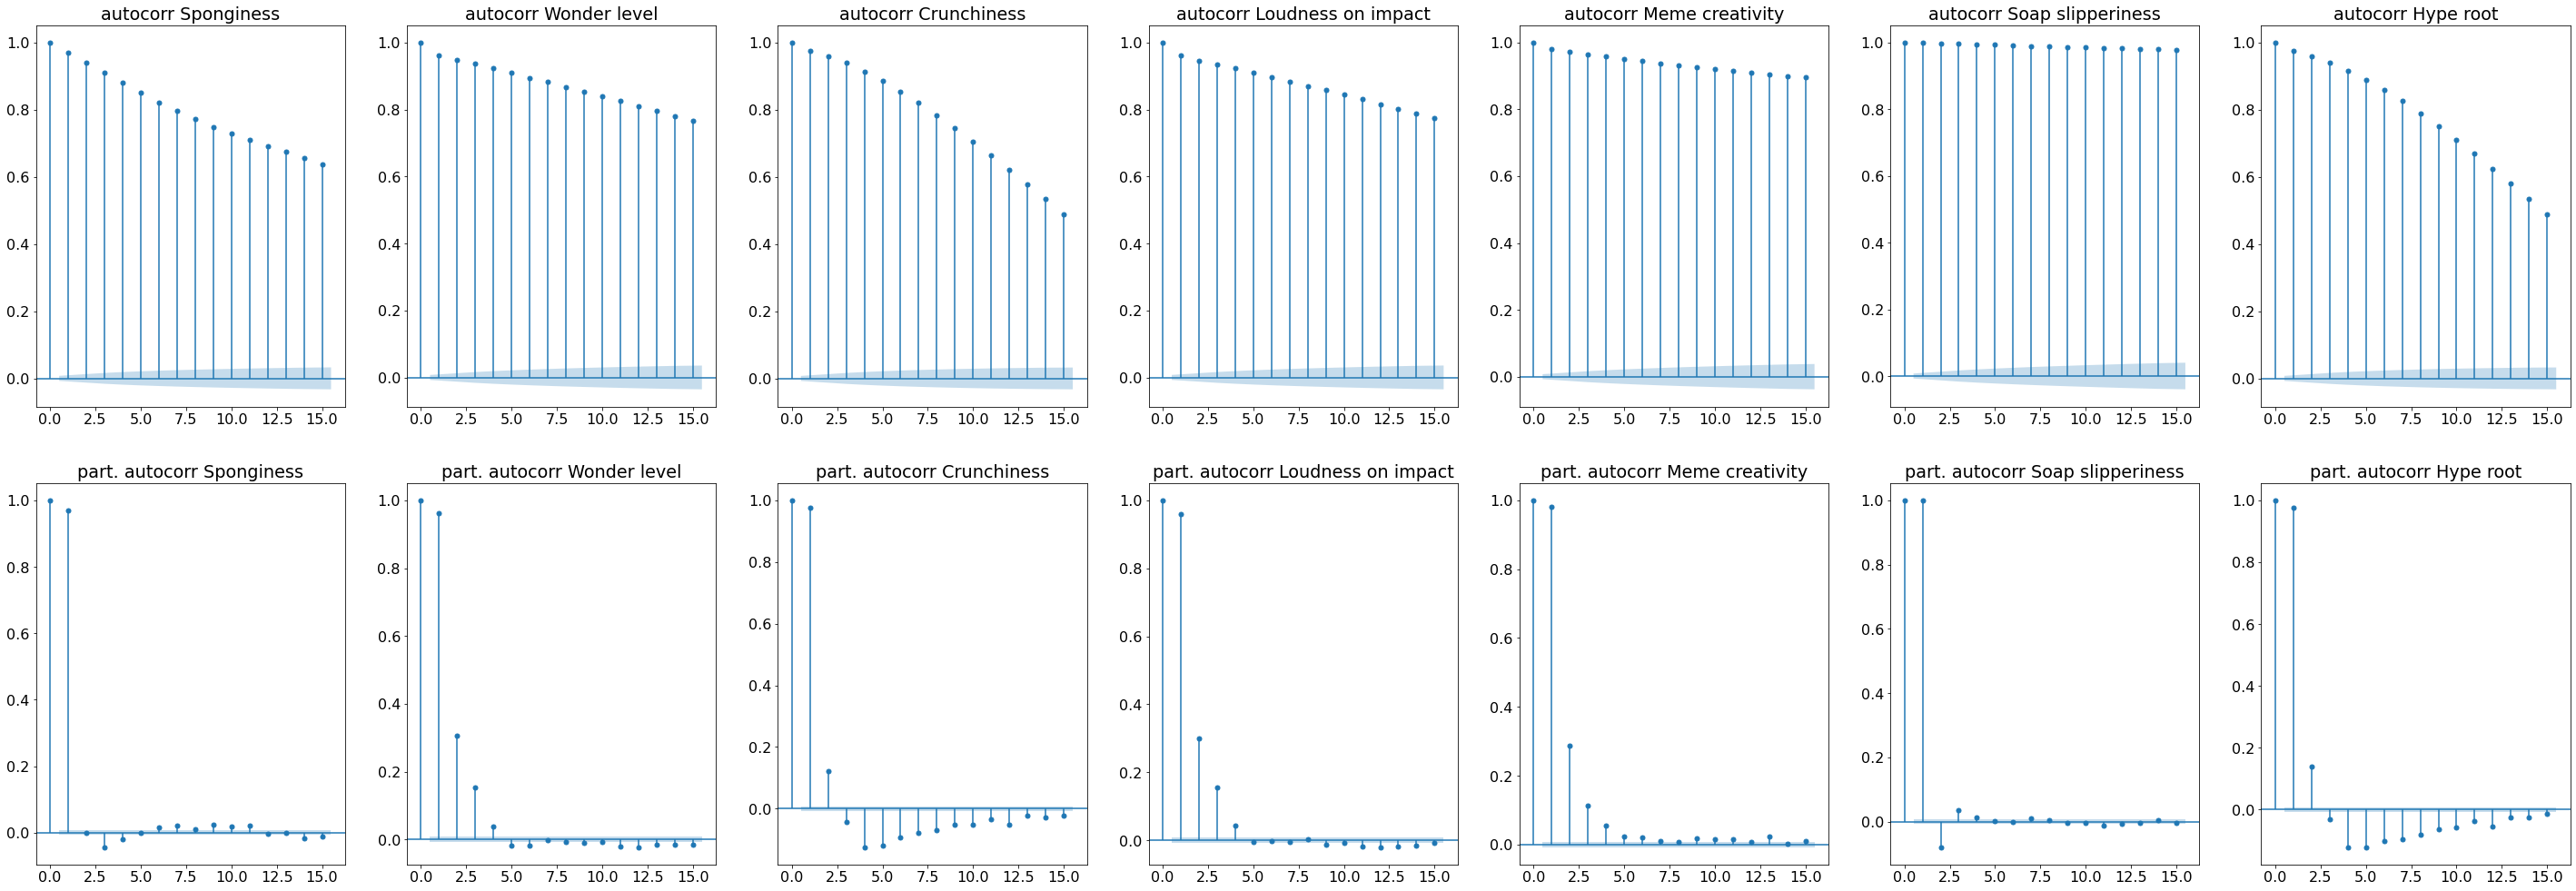

In [9]:
#plot, for each data series, the 15-lag Autocorrelation and Partial-Autocorrelation

figs, axs = plt.subplots(1,len(dataset.columns), sharex=True, figsize=(50,17))

for i in range(14):       
    ax = plt.subplot(2,7,i+1)
    if(i<7):
        plot_acf(dataset[dataset.columns[i]],lags=15,ax=ax)
        plt.title("autocorr "+dataset.columns[i])
    else:
        plot_pacf(dataset[dataset.columns[i%7]], alpha=.05,lags=15, ax=ax)
        plt.title("part. autocorr "+dataset.columns[i%7])
    
##>>>similar to ARs, as Autocorrelation tails off while Partial-Autocorrelation cuts and gets close (not always inside) to the interval of confidence  

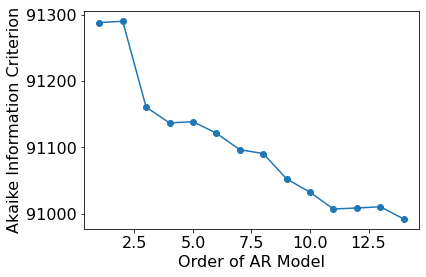

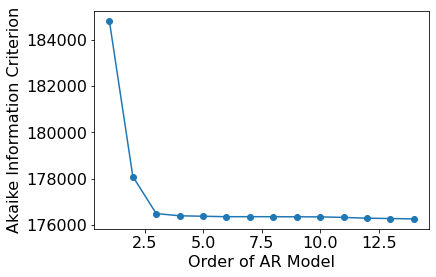

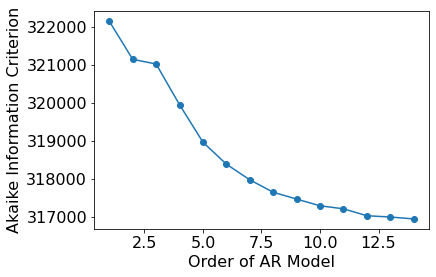

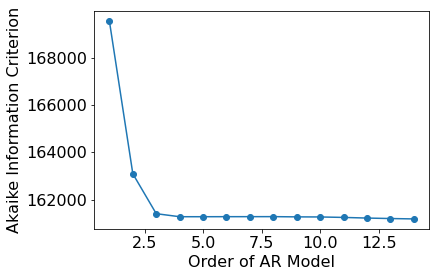

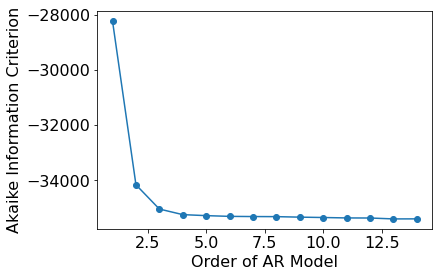

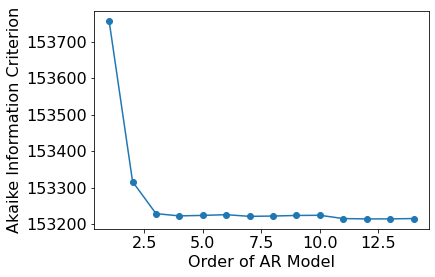

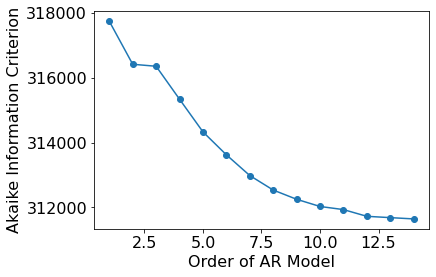

In [10]:
#use AIC criterion to find the best order for the series

from statsmodels.tsa.arima_model import ARMA

max_model_order = 15

for i in range(7):
    AIC = np.zeros(max_model_order)
    for ar_order in range(max_model_order):
        model = ARMA(dataset[dataset.columns[i]],order=(ar_order,0))
        result = model.fit(disp=0)

        AIC[ar_order] = result.aic

    plt.plot(range(1,max_model_order), AIC[1:max_model_order], marker='o')
    plt.xlabel('Order of AR Model');
    plt.ylabel('Akaike Information Criterion');
    plt.show()

# DIFF

In [11]:
#Non-stationary series can be transformed into stationary ones through simple functions like diff for example. 

In [12]:
dataset.head(10).diff()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.10126,0.11122,-0.111220,-0.05976,0.10126,-0.117862,-0.17762
2,-0.04980,-0.22244,0.000000,-0.05810,-0.15106,-0.700518,0.00000
3,0.00000,0.00000,0.000000,0.05810,0.00000,-5.021499,0.00000
4,-0.15272,0.22244,-0.111221,0.00000,0.10126,1.284840,0.00000
5,-0.04980,-0.22244,-0.333660,-0.05810,-0.15272,-0.116203,-0.05810
6,-0.30378,-0.11122,-0.222441,-0.05976,0.10126,-0.117859,-0.17762
7,-0.20252,-0.11122,-0.333660,-0.05810,-0.10126,-0.932920,0.00000
8,-0.04980,-0.11122,0.000000,0.05810,-0.10126,1.166982,-0.11786
9,0.00000,0.11122,0.000000,0.11786,-0.04980,-0.466460,0.11786


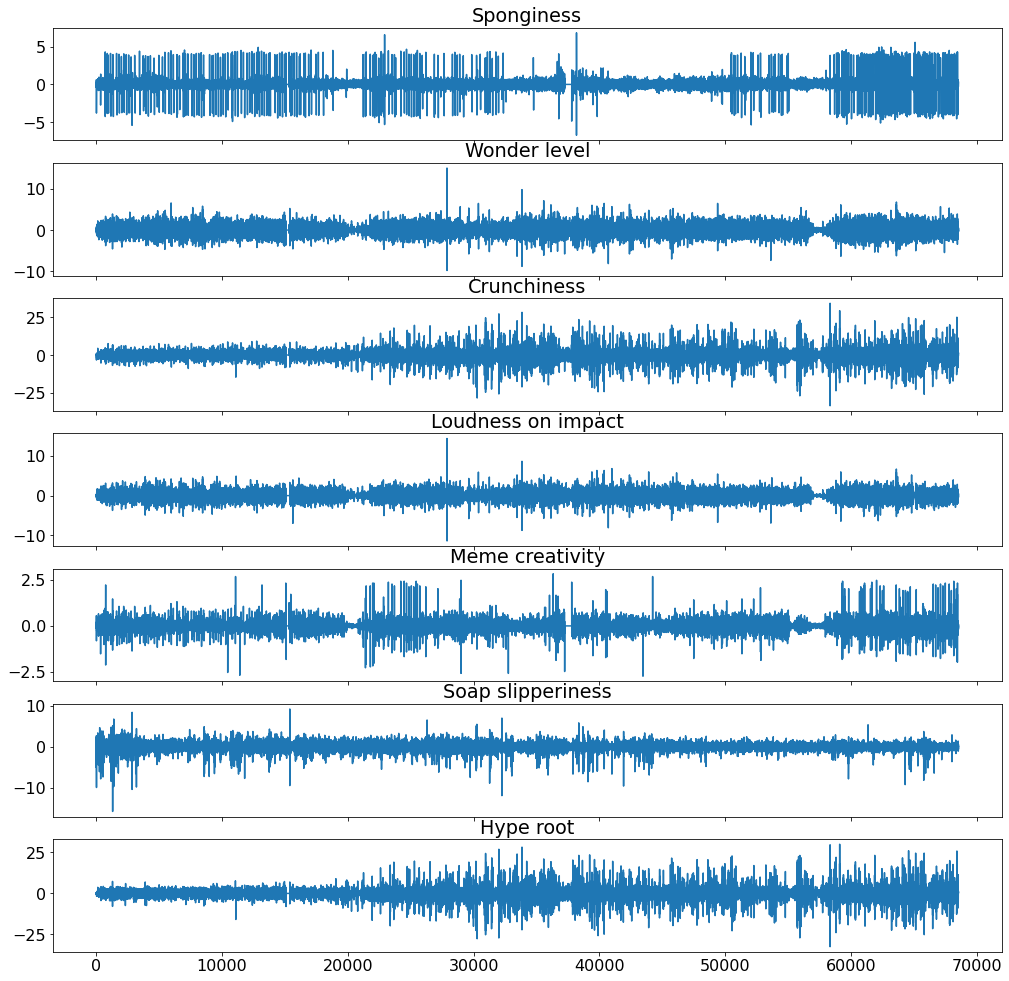

In [13]:
#function to plot the dataset, dividing it in subplots, one for each feature
def inspect_dataframe_diff(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df.diff()[col])
        axs[i].set_title(col)
    plt.show()

inspect_dataframe_diff(dataset, dataset.columns)

# TREND AND SEASONALITY

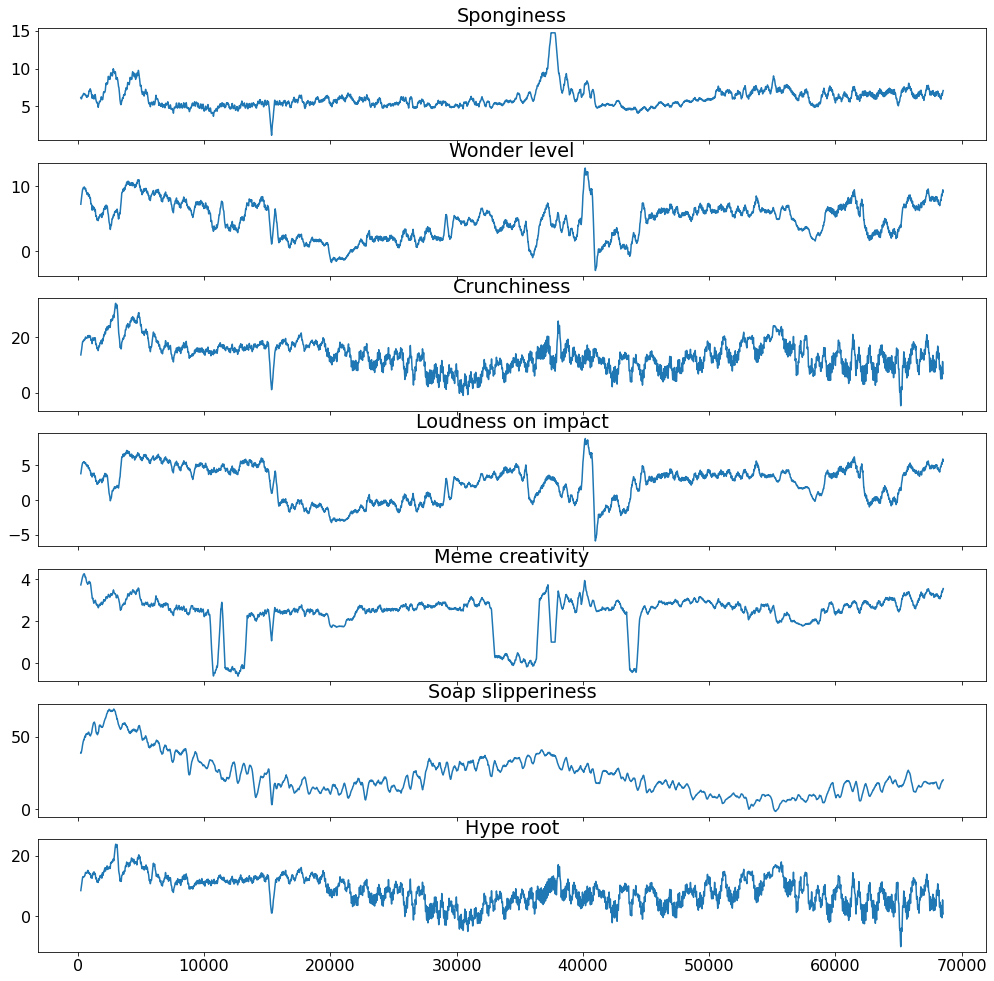

In [14]:
# Mean inspection
def inspect_mean(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(dataset[col].rolling(250).mean())
        axs[i].set_title(col)
    plt.show()
inspect_mean(dataset, dataset.columns)

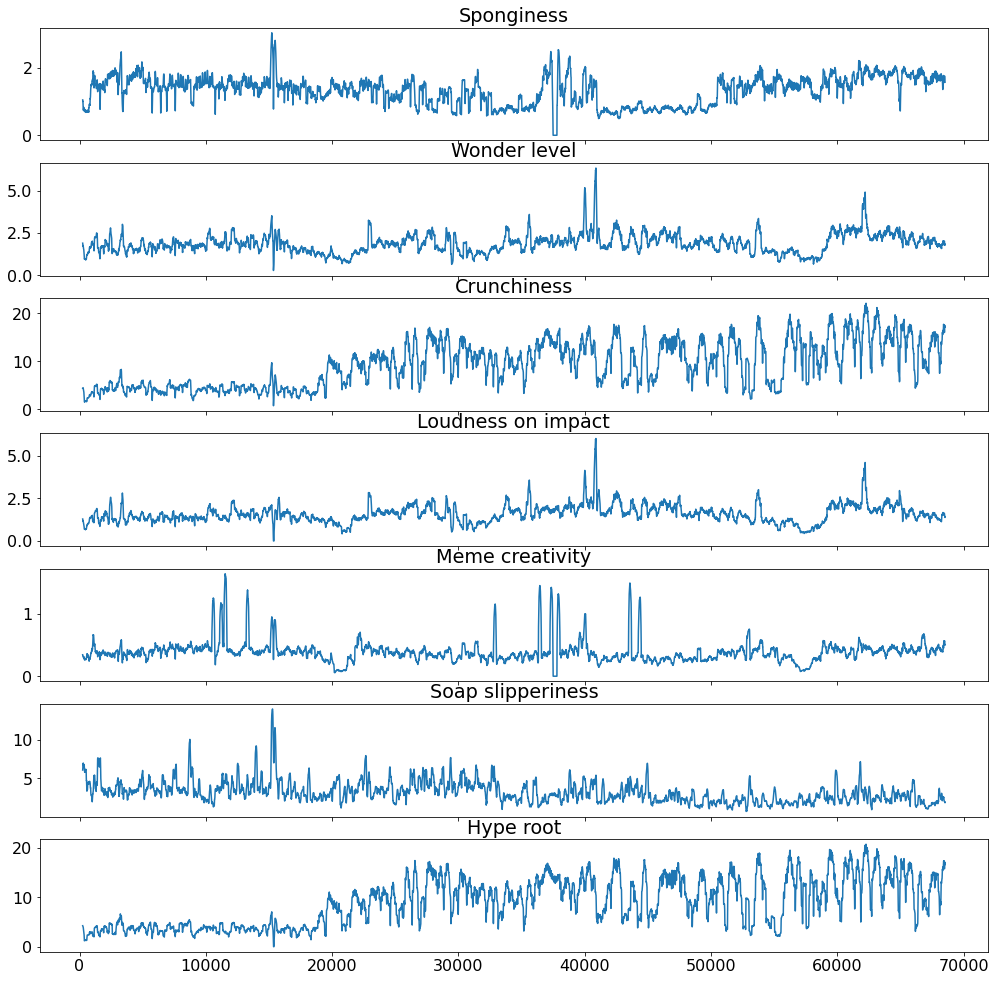

In [15]:
# Standard deviation inspection
def inspect_std(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(dataset[col].rolling(250).std())
        axs[i].set_title(col)
    plt.show()
inspect_std(dataset, dataset.columns)

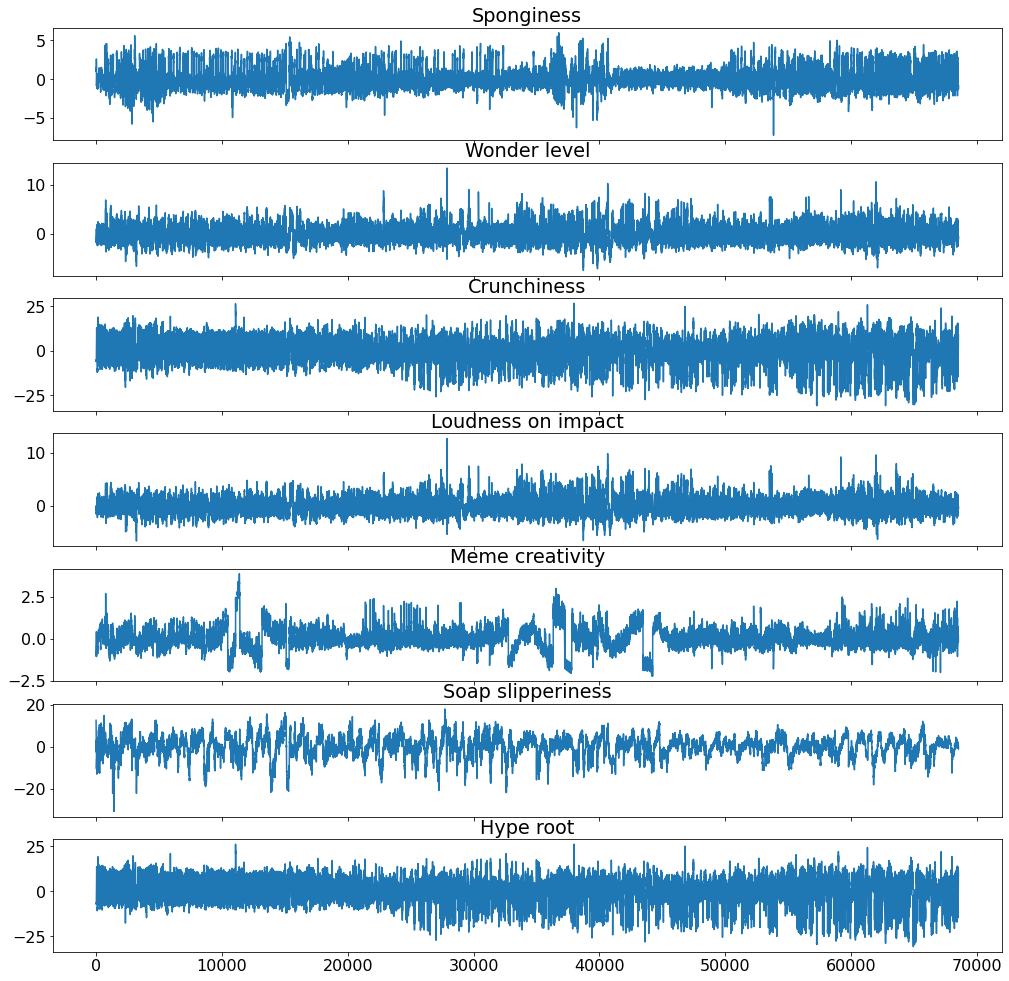

In [16]:
# Extract residuals from each one of the data series in order to obtain a stationary dataset 
from seasonal import fit_seasons, adjust_seasons

for i,col in enumerate(dataset.columns):
    seasons, trend = fit_seasons(dataset[col])
    adjusted = adjust_seasons(dataset[col], seasons=seasons)
    residual = adjusted - trend
    if (i==0):
        stationary_dataset = residual.to_frame(name=col)
    else:
        stationary_dataset = pd.concat([stationary_dataset,residual.to_frame(name=col)], axis=1)

dataset=stationary_dataset

inspect_dataframe(dataset, dataset.columns)